In [1]:
"""
Notebook conclusion
My implementation of the Wishart log_pdf ranks solutions identially to scipy
"""

import jax
import jax.numpy as jnp
import jax.scipy as jsp
import pyext.src.ulpdf as ulpdf
import scipy.stats as stats
import pyext.src.matrix as mat
import pyext.src.pynet_rng as rng
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl

mpl.rcParams['font.size'] = 16


In [2]:
p = 7
O = np.ones((p, p))
diags = np.diag_indices(p)
nu = p + 1
O[diags] = 2.1
O[0, 3] = -1.3
O[3, 5] = -1.7
O[4, 6] = 2.19278
V = 1/p * O
rseed = 2098
key = jax.random.PRNGKey(rseed)
assert mat.is_positive_definite(V)


In [3]:
sp_wish = stats.wishart(df=nu, scale=V)
def sp_vs_my_implementation(key, V, nu, p):
    A = rng.standard_wishart(key, p, nu)
    L = jsp.linalg.cholesky(V, lower=True)
    S = L @ A @ A.T @ L.T
    
    sp_lpdf = sp_wish.logpdf(S)
    my_lpdf = ulpdf.wish_bart(A, nu, L, p)
    my_lpdf_S = ulpdf.wish_bart_from_S(S, nu, L, p)
    return sp_lpdf, my_lpdf, my_lpdf_S

ntests = 1000
k1 = key
results = np.zeros((ntests, 3))
for i in range(ntests):
    key, k1 = jax.random.split(k1)
    sp_lpdf, my_lpdf, my_lpdf_S = sp_vs_my_implementation(key, V, nu, p)
    results[i, 0] = sp_lpdf
    results[i, 1] = my_lpdf
    results[i, 2] = my_lpdf_S


Text(0, 0.5, 'my log pdf')

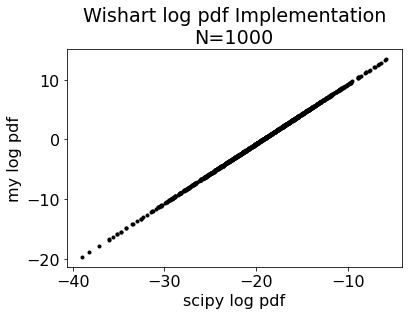

In [4]:
plt.plot(results[:, 0], results[:, 1], 'k.')
plt.title(f"Wishart log pdf Implementation\nN={ntests}")
plt.xlabel("scipy log pdf")
plt.ylabel("my log pdf")

Text(0, 0.5, 'my log pdf')

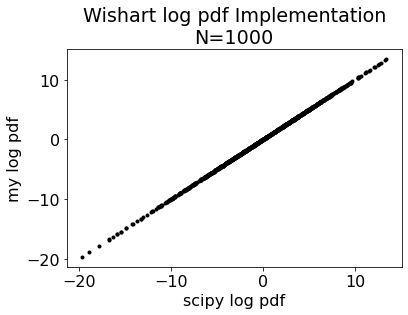

In [5]:
plt.plot(results[:, 1], results[:, 2], 'k.')
plt.title(f"Wishart log pdf Implementation\nN={ntests}")
plt.xlabel("scipy log pdf")
plt.ylabel("my log pdf")

Text(0, 0.5, 'my log pdf')

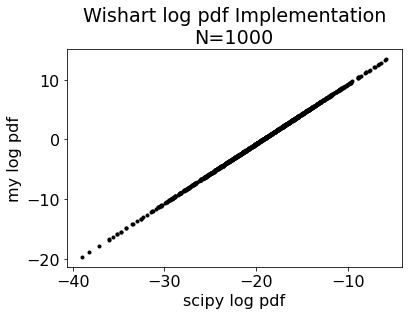

In [6]:
plt.plot(results[:, 0], results[:, 2], 'k.')
plt.title(f"Wishart log pdf Implementation\nN={ntests}")
plt.xlabel("scipy log pdf")
plt.ylabel("my log pdf")

In [7]:
# Compare the speed of execution
import timeit
from functools import partial
L = jsp.linalg.cholesky(V, lower=True)
A = rng.standard_wishart(key, p, nu)
S = L @ A @ A.T @ L.T

spwish = stats.wishart(df=nu, scale=V)
my_wish = ulpdf.wish_bart
f = partial(ulpdf.wish_bart, p=p)
jwish = jax.jit(f)


In [8]:
%timeit spwish.logpdf(S)

117 µs ± 1.57 µs per loop (mean ± std. dev. of 7 runs, 10,000 loops each)


In [9]:
%timeit my_wish(A, nu, L, p).block_until_ready()

1.91 ms ± 2.95 µs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)


In [10]:
jwish(A, nu, L)

DeviceArray(5.420307, dtype=float32)

In [11]:
%timeit jwish(A, nu, L).block_until_ready()

14.3 µs ± 27.1 ns per loop (mean ± std. dev. of 7 runs, 100,000 loops each)


In [12]:
f2 = partial(f, nu=nu, L=L, p=p)
jf2 = jax.jit(f2)
jf2(A).block_until_ready()

DeviceArray(5.420307, dtype=float32)

In [13]:
%timeit jf2(A).block_until_ready()

12.7 µs ± 38.2 ns per loop (mean ± std. dev. of 7 runs, 100,000 loops each)


In [14]:
%timeit numpy_version(A, nu, L, p)

NameError: name 'numpy_version' is not defined

In [15]:
# Custom Numpy and Scipy
import scipy as sp
def numpy_version(A, nu, L, p):
    log_det_V = 2 * np_log_det_tri(L)                                                                                                                                
    log_det_S = 2 * np_log_det_tri(A) + log_det_V                                                                                                             
    trace_term = - np_trace_term(L, A)                                                                                                                    
    log_gamma = sp.special.multigammaln(nu , p)                                                                                    
    s = (0.5 * (nu - 1 - p) * log_det_S - (0.5 * trace_term) - (0.5 * (nu * p) * np.log(2)) - (0.5 * nu) * log_det_V - log_gamma)            
    return -s


def np_log_det_tri(T):
    return np.sum(np.log(T.diagonal()))

def np_trace_term(L, A):
    return np.trace(sp.linalg.inv(L.T) @ A @ A.T @ L.T)


In [16]:
numpy_version(A, nu, L, p)

5.4202979037677395

In [17]:
import pandas as pd
# Mini Benchmark Results
rows = ['sp frozen lpdf(S| n, V)', 'my_imp', 'my_jit', 'my_jf2', 'numpy']
columns = ['mean (micro s)', 'std', 'log10 nloops' ]
data = np.array([[113, 0.226, 5],
                 [1930, 18.8, 2],
                 [15.9, 0.53, 5],
                 [12.5, 0.556, 5],
                 [615, 11.8, 4]])
micro_benchmark = pd.DataFrame(index=rows, columns=columns, data=data)



Text(0, 0.5, 'mean time per loop (µs)')

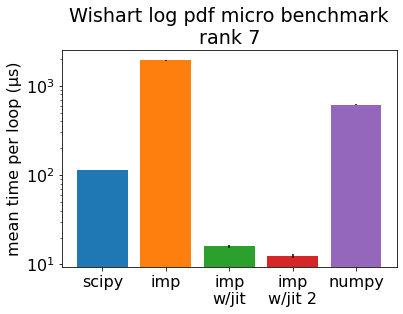

In [18]:
cm = mpl.cm.tab10
ax = plt.bar(np.arange(len(micro_benchmark)), 
        micro_benchmark.iloc[:, 0].values, 
        yerr=micro_benchmark.iloc[:, 1],
        color=cm.colors[0:5],
        tick_label=['scipy', 'imp', 'imp\nw/jit', 'imp\nw/jit 2', 'numpy'])
#ticks = ax.get_xticks()
#ax.set_xticks(ticks, labels=list(micro_benchmark.index))
plt.title(f"Wishart log pdf micro benchmark\nrank {p}")
plt.yscale("log")
plt.ylabel("mean time per loop (µs)")
#plt.xticks(labels=list(micro_benchmark.index))

In [19]:
"""
How does the scipy log pdf my log pdf rank samples generated from scipy?
"""
spwish = stats.wishart(df=nu, scale=V)
n_samples = 10000
spwish_samples = spwish.rvs(n_samples)
spwish_logpdfs = np.zeros(n_samples)

for i in range(n_samples):
    spwish_logpdfs[i] = spwish.logpdf(spwish_samples[i])

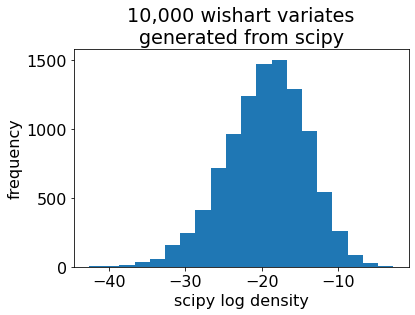

In [20]:
plt.hist(spwish_logpdfs, bins=20)
plt.xlabel("scipy log density")
plt.ylabel("frequency")
plt.title(f"{'{:,}'.format(n_samples)} wishart variates\ngenerated from scipy")
plt.show()

In [21]:
impwish = np.zeros((n_samples, p, p))
gwish = partial(rng.wishart, V=V, n=nu, p=p)
gwish = jax.jit(gwish)
for i in range(n_samples):
    key, k1 = jax.random.split(k1)
    impwish[i] = gwish(key=key)

In [22]:
impwish_lpdfs = np.zeros(n_samples)
for i in range(n_samples):
    impwish_lpdfs[i] = spwish.logpdf(impwish[i])

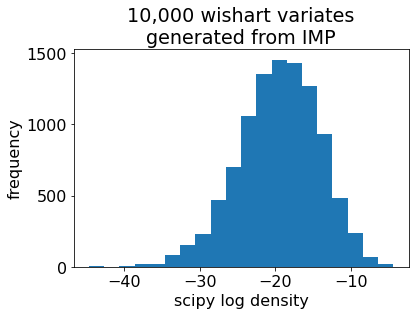

In [23]:
plt.hist(impwish_lpdfs, bins=20)
plt.xlabel("scipy log density")
plt.ylabel("frequency")
plt.title(f"{'{:,}'.format(n_samples)} wishart variates\ngenerated from IMP")
plt.show()

In [24]:
impwish_lpdfs

array([-16.24783995, -29.02949049, -27.67708546, ..., -19.4338746 ,
       -18.68935774, -14.21740177])

In [ ]:
stats.ks_2samp(impwish_lpdfs, spwish_logpdfs)

In [49]:
# Micro benchmark of 1500 dimensional multivariate normal
def set_up_microbenchmark(n):
    key = jax.random.PRNGKey(13)
    key, k1, k2, k3 = jax.random.split(key, 4)
    lpdf = jsp.stats.multivariate_normal.logpdf
    f = jax.jit(lpdf)

    y = jax.random.normal(k1, shape=(n,))
    mus = jax.random.normal(k2, shape=(n,))
    Sigma = rng.standard_wishart(k3, p=n, n=n)
    V2 = np.ones((n, n))
    V2[np.diag_indices(n)] = 3
    L2 = jsp.linalg.cholesky(V2)
    Sigma = L2 @ Sigma @ Sigma.T @ L2.T
    Sigma = np.array(Sigma)
    Sigma[np.diag_indices(n)] = Sigma[np.diag_indices(n)]
    assert mat.is_positive_definite(Sigma)

    f(y, mus, Sigma)
    return f, y, mus, Sigma

In [113]:
f, y, mus, Sigma = set_up_microbenchmark(1500)

In [109]:
g = sp.stats.multivariate_normal(mus, Sigma).logpdf

In [114]:
%timeit sp.stats.multivariate_normal.logpdf(y, mus, Sigma)

541 ms ± 4.11 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


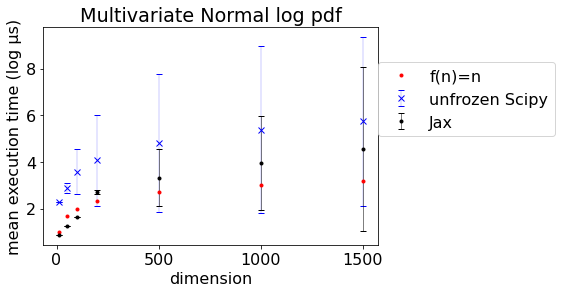

In [135]:
dimension = [10, 50, 100, 200, 500, 1000, 1500]
time = [7.36, 18, 41.4, 496, 2130, 8630, 35700]
unfrozen_sp = [182, 772, 3730, 11600, 64400, 245000, 541000]
unfrozen_std = [0.0582, 1.6, 9.33, 86.8, 946, 3810, 4110]
unfrozen_std = [1, 1.6, 9.33, 86.8, 946, 3810, 4110] # remove small errors


sp_time = [22.7, 23.7, 69, 67.2, 81.5, ]
sp_std = [1.4, 0.174, 7.11, 0.198, 3.27]
logtime = np.log10(time)
stds = [0.0388, 0.0486, 0.138, 1.22, 16.8, 103, 3290]
stds = [1,      1,          1, 1.22, 16.8, 103, 3290]
#log_error = np.log10(stds)




plt.errorbar(dimension, np.log10(unfrozen_sp), 
             yerr=np.log10(unfrozen_std),
             fmt="bx", 
             label="unfrozen Scipy",
             elinewidth=0.2,
             capsize=3)
plt.errorbar(dimension, logtime, fmt='k.', 
             yerr=np.log10(stds),
             label="Jax",
             elinewidth=0.5,
             capsize=3)
plt.plot(dimension, np.log10(dimension), 'r.', label="f(n)=n")
plt.ylabel("mean execution time (log µs)")
plt.xlabel("dimension")
plt.title("Multivariate Normal log pdf")
plt.legend(loc=(1, 0.5))

In [141]:
a, b = timeit.timeit('sp.stats.multivariate_normal.logpdf(y, mus, Sigma)', globals=globals())

KeyboardInterrupt: 

In [142]:
?%timeit

In [28]:
def set_up_wishart(p):
    key = jax.random.PRNGKey(13)
    key, k1, k2 = jax.random.split(key, 3)
    O = np.ones((p, p))
    diags = np.diag_indices(p)
    nu = p + 1
    O[diags] = n * 2.1
    O[0, 3] = -1.3
    O[3, 5] = -1.7
    O[4, 6] = 2.19278
    V = 1/p * O
    rseed = 2098
    assert mat.is_positive_definite(V)
    A = rng.standard_wishart(key, p, p)
    L = jsp.linalg.cholesky(V)
    def f(A, nu, L):
        return ulpdf.wish_bart(A, nu, L, p)
    f = jax.jit(f)

    f(A, p, L)
    S = L @ A @ A.T @ L.T
    assert mat.is_positive_definite(S)
    return f, A, p, L, V
    

/tmp/ipykernel_601846/3236004994.py:5: RuntimeWarning: divide by zero encountered in log10
  log10n2 = np.log10(np.power(dx, 2))
/tmp/ipykernel_601846/3236004994.py:19: RuntimeWarning: divide by zero encountered in log10
  plt.plot(dx, np.log10(dx), 'r-', label="f(n)=n")


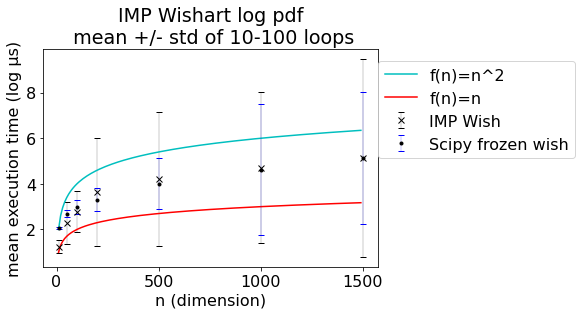

In [149]:
dimension = [10, 50, 100, 200, 500, 1000, 1500]


dx = np.arange(0, 1500, 10)
log10n2 = np.log10(np.power(dx, 2))
wisht = [17.8, 198, 597, 4320, 16200, 51500, 135000]
wishstd = [1.98, 8.21, 7.99, 234, 848, 2080, 21600]
sp_wisht = [117, 496, 964, 2000, 10200, 41700, 131000]
sp_wishstd = [1.13, 1.42, 2., 3.17, 12.8, 734, 776]

plt.errorbar(dimension, 
             np.log10(wisht), 
             yerr=np.log10(wishstd), 
             fmt='kx', label="IMP Wish",
             elinewidth=0.2,
             capsize=3)

plt.plot(dx, log10n2, 'c-', label="f(n)=n^2")
plt.plot(dx, np.log10(dx), 'r-', label="f(n)=n")
#plt.plot(dx, np.log10(np.power(dx, 3)), 'k--', label="f(n)=n^3")
plt.errorbar(dimension, np.log10(sp_wisht),
            yerr=np.log10(sp_wishstd),
            fmt='k.',
            label="Scipy frozen wish",
            elinewidth=0.2,
            ecolor='b',
            capsize=3)
plt.ylabel("mean execution time (log µs)")
plt.xlabel("n (dimension)")
plt.title("IMP Wishart log pdf\n mean +/- std of 10-100 loops")
plt.legend(loc=(1, 0.5))
plt.show()

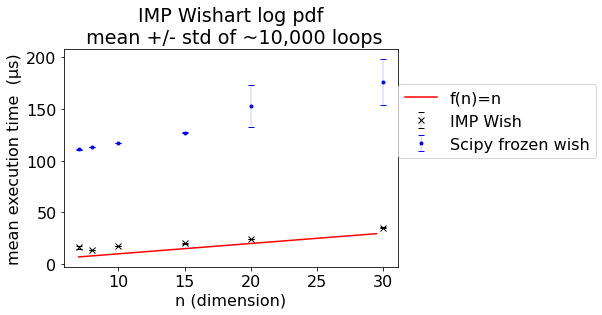

In [143]:
dimension = [7, 8, 10, 15, 20, 30]

wisht = [16.3, 14, 17.3, 20.3, 24.2, 35.3]
wishstd = [1.74, 0.0741, 0.0516, 0.617, 0.0972, 0.182]
sp_wisht = [111, 113, 117, 127, 153, 176]
sp_wishstd = [0.479, 0.072, 0.069, 0.495, 20.2, 22.3]
dx = np.arange(7, 30, 0.5)
log10n2 = np.log10(np.power(dx, 2))


plt.errorbar(dimension, 
             wisht, 
             yerr=wishstd, 
             fmt='kx', label="IMP Wish",
             elinewidth=0.2,
             capsize=3)

plt.errorbar(dimension,
            sp_wisht,
            yerr=sp_wishstd,
            fmt='b.',
            elinewidth=0.2,
            ecolor='b',
            capsize=3,
            label="Scipy frozen wish")
#plt.plot(dx, np.power(dx, 2), 'c-', label="f(n)=n^2")
plt.plot(dx, dx, 'r-', label="f(n)=n")
#plt.plot(dx, np.power(dx, 3), 'k--', label="f(n)=n^3")
plt.ylabel("mean execution time  (µs)")
plt.xlabel("n (dimension)")
plt.title(f"IMP Wishart log pdf\n mean +/- std of ~{'{:,}'.format(10000)} loops")
plt.legend(loc=(1, 0.5))
plt.show()

In [35]:
a = (np.array(wisht) / np.array(sp_wisht))
am = np.mean(a)
astd = np.std(a)

6.402154291364426

In [ ]:
p=30
fa, Aa, pa, La, Va = set_up_wishart(p)

In [ ]:
%timeit fa(Aa, pa, La).block_until_ready()

In [ ]:
S = La @ Aa @ Aa.T @ La.T

In [ ]:
f = sp.stats.wishart(df=p, scale=Va).logpdf

In [ ]:
%timeit f(S)

In [ ]:
def set_up_beta_binomial_synthetic_benchmark(n):
    ntrials = 0.5 * n * (n-1)
    def f(x, alpha, beta):
        return jsp.stats.betabinom.logpmf(x, ntrials, alpha, beta)
    
    f = jax.jit(f)
    x = jnp.

In [ ]:
?jsp.stats.betabinom.logpmf

In [ ]:
f, y, mus, Sigma = set_up_microbenchmark(10)

In [ ]:
%timeit f(y, mus, Sigma).block_until_ready()